Using TensorFlow backend.


epochs : 0
Epoch 1/1
41061/41061 [==============================] - 481s 12ms/step - loss: 0.1965 - accuracy: 0.9740
epochs : 1
Epoch 1/1
41061/41061 [==============================] - 532s 13ms/step - loss: 0.1575 - accuracy: 0.9745


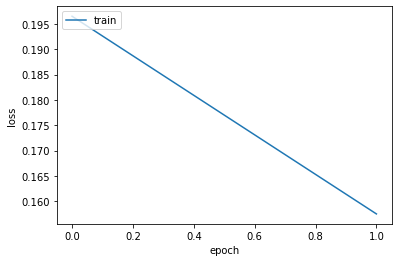

24968/41061 [=================>............] - ETA: 34s

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils
from keras.optimizers import RMSprop
import decimal
import json
import numpy as np
import time
import copy

#랜덤 시드 고정
np.random.seed(1986)

MAXINF = 9999.0
MININF = -9999.0

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
def FindArea(json_data):
    min_loc=[MAXINF,MAXINF]
    max_loc=[MININF,MININF]
    
    for x in json_data:
        if float(x['latitude']) > max_loc[0]:
            max_loc[0] = float(x['latitude'])
        if float(x['longitude']) > max_loc[1]:
            max_loc[1] = float(x['longitude'])
        if float(x['latitude']) < min_loc[0]:
            min_loc[0] = float(x['latitude'])
        if float(x['longitude']) < min_loc[1]:
            min_loc[1] = float(x['longitude'])
            
    return min_loc,max_loc

def SeparateByTime(json_data):
    import copy
    tmp_json_data,st=[],0
    track_by_date = {}
    for i in range(len(json_data)-1):
        
        today = time.strftime('%Y-%m-%d',time.localtime(float(json_data[i]['timestamp'])))
        tomorrow = time.strftime('%Y-%m-%d',time.localtime(float(json_data[i+1]['timestamp'])))
        
        if today != tomorrow:
            tmp_list=[]
            for j in range(st,i+1):
                tmp_list.append([float(json_data[j]['latitude']),float(json_data[j]['longitude'])])
            if today in track_by_date:
                track_by_date[today].append(copy.deepcopy(tmp_list))
            else:
                track_by_date[today]=copy.deepcopy(tmp_list)
            st=i+1
    
    tmp_list=[]
    for i in range(st,len(json_data)):
        tmp_list.append([float(json_data[i]['latitude']),float(json_data[i]['longitude'])])
    if today in track_by_date:
        track_by_date[today]+=copy.deepcopy(tmp_list)
    else:
        track_by_date[today]=copy.deepcopy(tmp_list)

    return track_by_date

def GetDrowAndDcol(min_loc,max_loc,side_cnt):
    # 0 : latitude 
    # 1 : longitude
    # if side_length is 10, label range is [0~99]
    row = max_loc[1]-min_loc[1]
    col = max_loc[0]-min_loc[0]

    drow = row / side_cnt
    dcol = col / side_cnt
    
    return drow,dcol


def GetLabelFromLocation(min_loc,drow,dcol,loc,side_cnt):
    label=0
    for i in range(1,side_cnt+1):
        if min_loc[1]+drow*i > loc[1]:
            label = i-1
            break
    else:
        label = side_cnt-1
    for i in range(1,side_cnt+1):
        if min_loc[0]+dcol*i > loc[0]:
            label += side_cnt*(i-1)
            break
    else:
        label+= side_cnt*(side_cnt-1)
        
    return label

def MakeTrainSet(min_loc,drow,dcol,side_cnt,loc_list,track_length):
    x_train_part=[]
    y_train_part=[]
    
    for ed in range(track_length,len(loc_list)):
        x_tmp=[ GetLabelFromLocation(min_loc,drow,dcol,x,side_cnt) for x in loc_list[ed-track_length:ed]]
        y_tmp=GetLabelFromLocation(min_loc,drow,dcol,loc_list[ed],side_cnt)
        x_train_part.append(copy.deepcopy(x_tmp))
        y_train_part.append(y_tmp)

    return x_train_part,y_train_part
    

def MakeDataset(filename,track_length=4,side_cnt=24):
    with open(filename,'r') as open_file:
        json_data = json.load(open_file)
        
    if len(json_data)==0:
        print("data is empty error")
        return False
    
    min_loc,max_loc = FindArea(json_data)
    json_data = SeparateByTime(json_data)
    
    #     for x,y in json_data.items():
    #     print(x,len(y))
    
    drow,dcol = GetDrowAndDcol(min_loc,max_loc,side_cnt)
    
    
    x_train=[]
    y_train=[]


    for date,loc_list in json_data.items():
        if len(loc_list) < track_length+1:
            continue
        x_tmp,y_tmp = MakeTrainSet(min_loc,drow,dcol,side_cnt,loc_list,track_length)
        x_train+=copy.deepcopy(x_tmp)
        y_train+=copy.deepcopy(y_tmp)

    x_train=np.array(x_train)
    y_train=np.array(y_train)
    
    # 입력값 정규화 시키기
    x_train = x_train / float(side_cnt**2)
    
    # 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
    x_train = np.reshape(x_train, (len(x_train), track_length, 1))


    # 라벨값에 대한 one-hot 인코딩 수행
    y_train = np_utils.to_categorical(y_train,num_classes=side_cnt**2)

    return x_train,y_train

def GetLSTMModel(track_length,one_hot_vec_size):
    model = Sequential()
    model.add(LSTM(128, batch_input_shape = (1, track_length, 1), stateful=True))
    model.add(Dense(one_hot_vec_size, activation='softmax'))
    return model


def Training(filename="gpx.json",epochs=2,track_length=4,side_cnt=24):
    
    #데이터 셋 만들기
    x_train,y_train = MakeDataset(filename,track_length,side_cnt)
    
    #모델 가져오기
    model = GetLSTMModel(track_length,len(y_train[0]))
    
    #모델 컴파일
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 5. 모델 학습시키기
    num_epochs = epochs

    history = LossHistory() # 손실 이력 객체 생성

    history.init()

    for epoch_idx in range(num_epochs):
        print ('epochs : ' + str(epoch_idx))
        model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1, shuffle=False, callbacks=[history]) 
        model.reset_states()

    # 6. 학습과정 살펴보기
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    plt.plot(history.losses)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # 7. 모델 평가하기
    scores = model.evaluate(x_train, y_train, batch_size=1)
    print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    model.reset_states()
    
    return scores[1]
    
Training()